In [ ]:
from util.save_utils import save_all_models_per_epoch, save_best_performing_model, save_configuration_output

In [ ]:
from constants import (
    BETA,
    NUMBER_INPUT_NEURONS,
    NUMBER_OUTPUT_NEURONS,
    THRESHOLD,
    TIME_STEPS,
)
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from training.train_snn import train_snn
from util.save_plots import save_history_plot, save_loss_per_time_step_plot

num_epochs = 'early_stopping'
sparsity = 0.2
number_hidden_neurons = 10
number_hidden_layer = 1
loss_configuration="population_coding"

model = ConfigurableSpikingNeuralNet(
    number_input_neurons=NUMBER_INPUT_NEURONS,
    number_hidden_neurons=number_hidden_neurons,
    number_output_neurons=NUMBER_OUTPUT_NEURONS,
    beta=BETA,
    threshold=THRESHOLD,
    time_steps=TIME_STEPS,
    number_hidden_layers=number_hidden_layer,
)

training_acc_history, test_acc_history, loss_history, total_training_time, epoch_loss_per_time_step, models_per_epoch, = train_snn(
    model,
    num_epochs=num_epochs,
    sparsity=sparsity,
    loss_configuration=loss_configuration,
    use_train_data_subset=1000
)

assert len(training_acc_history) == len(test_acc_history) == len(models_per_epoch)

save_best_performing_model(models_per_epoch, test_acc_history, './models/test.pth')

save_all_models_per_epoch(models_per_epoch, f'./models/test')

result_data = {
    "number_input_neurons": NUMBER_INPUT_NEURONS,
    "number_hidden_neurons": number_hidden_neurons,
    "number_output_neurons": NUMBER_OUTPUT_NEURONS,
    "beta": BETA,
    "threshold": THRESHOLD,
    "time_steps": TIME_STEPS,
    "number_hidden_layers": number_hidden_layer,
    "epochs": len(test_acc_history),
    "sparsity": sparsity,
    "loss_configuration": loss_configuration,
    "best_test_accuracy": np.max(test_acc_history),
    "training_accuracy": training_acc_history[np.argmax(test_acc_history)]
}

save_configuration_output(result_data, './output/test.json')

save_history_plot(training_acc_history, './output/test_train_acc.jpg')

save_history_plot(test_acc_history, './output/test_test_acc.jpg')

save_history_plot(loss_history, './output/test_loss.jpg')

if epoch_loss_per_time_step:
    save_loss_per_time_step_plot(epoch_loss_per_time_step, path=f'./output/test_loss_per_time_steps.png')

In [ ]:
from util.plot_layer_development import plot_layer_development

plot_layer_development(models_per_epoch, [f'Epoch {epoch}' for epoch in range(len(models_per_epoch))])

# Plot layer development overfitted model

In [11]:
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, BETA, THRESHOLD, TIME_STEPS

base_net = ConfigurableSpikingNeuralNet(
    number_input_neurons=NUMBER_INPUT_NEURONS,
    number_hidden_neurons=1000,
    number_output_neurons=NUMBER_OUTPUT_NEURONS,
    beta=BETA,
    threshold=THRESHOLD,
    time_steps=TIME_STEPS,
    number_hidden_layers=2,
)

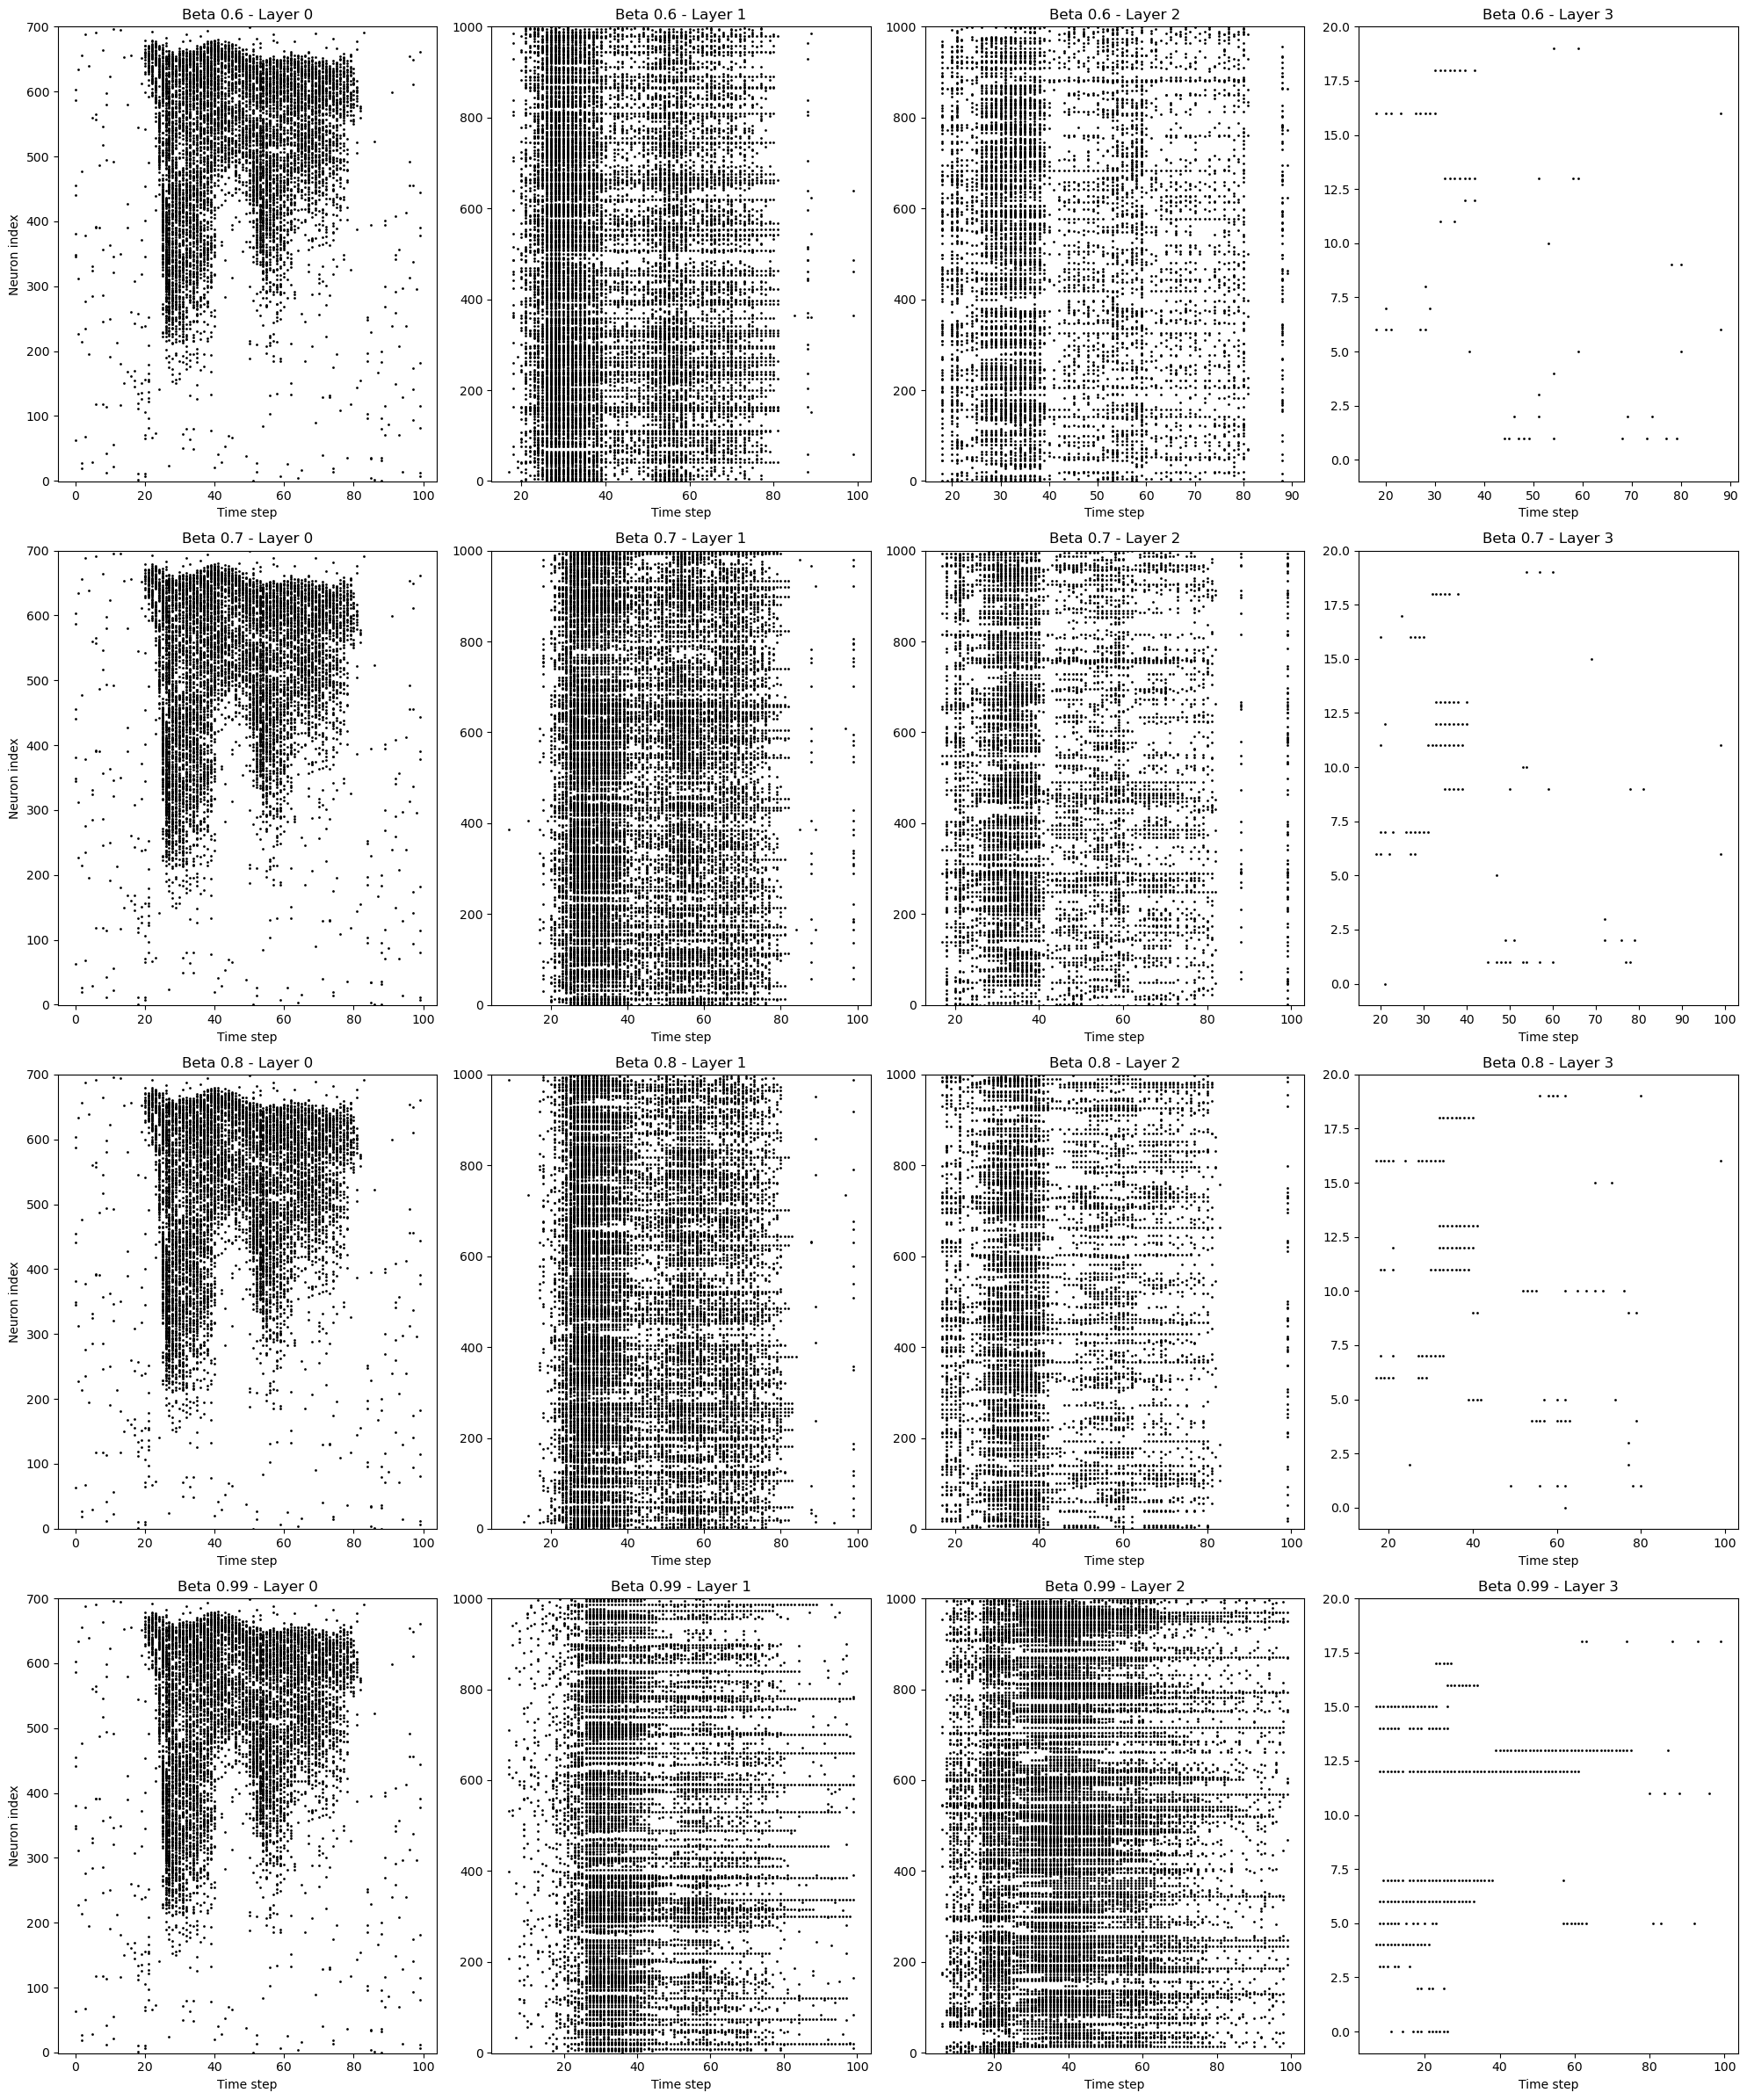

In [14]:
from util.plot_layer_development import plot_layer_development
import copy
import torch

models = []

paths = [
    './models/experiment_investigation_beta_vertical_alignment/beta_0.6.pth',
    './models/experiment_investigation_beta_vertical_alignment/beta_0.7.pth',
    './models/experiment_investigation_beta_vertical_alignment/beta_0.8.pth',
    './models/experiment_investigation_beta_vertical_alignment/beta_0.99.pth'
]


for path in paths:
    model = copy.deepcopy(base_net)

    model_path = path

    model.load_state_dict(torch.load(model_path))
    models.append(model)

plot_layer_development(models, [f'Beta {epoch}' for epoch in [0.6, 0.7, 0.8, 0.99]])